# Customer Segmentation (RFM + KMeans)

## Amaç
Bu notebook’ta işlem bazlı satış verisini (transaction-level) müşteri bazlı (customer-level) hale getirip:
- RFM (Recency, Frequency, Monetary) feature’larını üreteceğiz
- Veriyi ölçekleyip (scaling)
- KMeans ile müşteri segmentlerini çıkaracağız
- Segmentleri yorumlayacağız

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [4]:
sales_df = pd.read_csv("../data/processed/clean_data.csv")
sales_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,20.34


## Kontroller
- InvoiceDate: datetime mı?
- CustomerID: boş var mı?
- TotalPrice: negatif / sıfır var mı?

In [5]:
print(sales_df.dtypes)
print("CustomerID null:", sales_df["CustomerID"].isna().sum())
print("InvoiceDate null:", sales_df["InvoiceDate"].isna().sum())
print("TotalPrice <= 0:", (sales_df["TotalPrice"] <= 0).sum())

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
Year             int64
Month            int64
Day              int64
Hour             int64
TotalPrice     float64
dtype: object
CustomerID null: 0
InvoiceDate null: 0
TotalPrice <= 0: 0


In [6]:
sales_df["InvoiceDate"] = pd.to_datetime(sales_df["InvoiceDate"])

## Referans Tarih (Snapshot Date)
Recency hesaplamak için “bugün” gibi bir referans tarih seçeriz.
Genelde veri setindeki en son tarihin 1 gün sonrası seçilir.

In [7]:
snapshot_date = sales_df["InvoiceDate"].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

## RFM Hesaplama
- Recency: (snapshot_date - müşteri son alışveriş tarihi).days
- Frequency: müşteri kaç fatura (InvoiceNo) oluşturmuş?
- Monetary: müşteri toplam ne kadar harcamış? (TotalPrice toplamı)

In [8]:
rfm = sales_df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("TotalPrice", "sum")
).reset_index()

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [9]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


## Aykırı Değer Kontrolü
RFM’de bazı uç müşteriler (çok büyük harcama / çok fazla alışveriş) KMeans’i bozabilir.
Önce dağılımı gözlemleyelim.

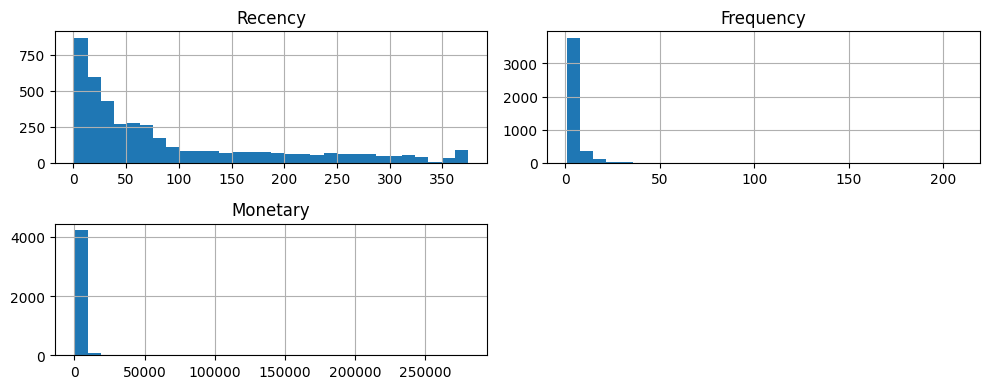

In [10]:
rfm[["Recency","Frequency","Monetary"]].hist(bins=30, figsize=(10,4))
plt.tight_layout()
plt.show()

In [11]:
rfm["Recency_log"] = np.log1p(rfm["Recency"])
rfm["Frequency_log"] = np.log1p(rfm["Frequency"])
rfm["Monetary_log"] = np.log1p(rfm["Monetary"])

In [12]:
X = rfm[["Recency_log","Frequency_log","Monetary_log"]]

In [13]:
rfm[["Recency_log","Frequency_log","Monetary_log"]].describe()

,Recency_log,Frequency_log,Monetary_log
count,4338.000000,4338.000000,4338.000000
mean,3.830734,1.345582,6.593627
std,1.340261,0.683104,1.257578
min,0.693147,0.693147,1.558145
25%,2.944439,0.693147,5.731446
50%,3.951244,1.098612,6.515431
75%,4.962845,1.791759,7.416222
max,5.926926,5.347108,12.543284


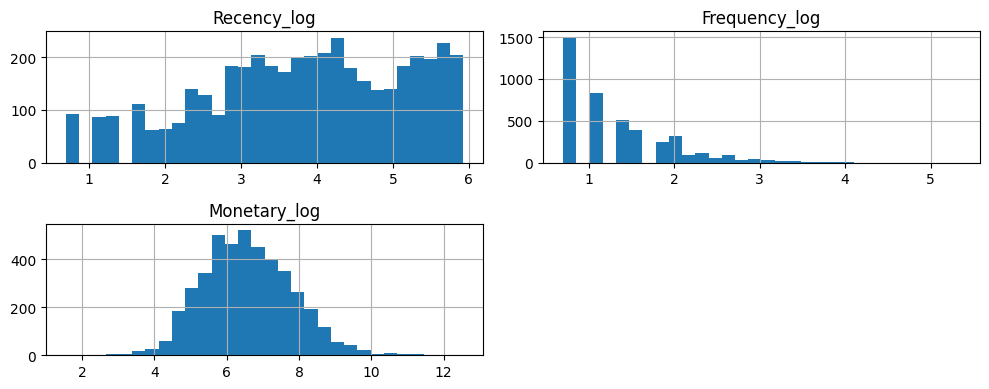

In [14]:
rfm[["Recency_log","Frequency_log","Monetary_log"]].hist(bins=30, figsize=(10,4))
plt.tight_layout()
plt.show()

## Log Transformation (Aykırı Değer Düzeltme ve Dağılım İyileştirme)

### Problem

RFM değişkenlerinin (Recency, Frequency, Monetary) dağılımı incelendiğinde:

- Değerlerin büyük çoğunluğu küçük değerlerde yoğunlaşmıştır.
- Çok az sayıda müşteri aşırı yüksek alışveriş sıklığı ve harcama değerlerine sahiptir.
- Bu durum sağa çarpık (right-skewed) dağılıma ve aykırı değerlere (outliers) neden olmaktadır.

Özellikle Monetary ve Frequency değişkenlerinde çok büyük değerler bulunması,
KMeans gibi mesafe tabanlı makine öğrenmesi algoritmalarının yalnızca büyük değerleri dikkate almasına neden olabilir.

Bu durum modelin performansını olumsuz etkiler ve müşteri segmentlerinin yanlış oluşmasına yol açabilir.

---

### Çözüm: Log Transform

Bu problemi azaltmak için logaritmik dönüşüm uygulanmıştır.

Kullanılan yöntem:

log(x + 1)  → numpy kütüphanesindeki `np.log1p()` fonksiyonu

Bu dönüşümün etkileri:

- Büyük değerlerin etkisini azaltır
- Veri dağılımını daha dengeli hale getirir
- Aykırı değerlerin model üzerindeki baskısını düşürür
- Değerleri sıkıştırarak ölçek farkını azaltır
- KMeans algoritmasının daha sağlıklı çalışmasını sağlar

---

### Neden np.log1p Kullanıldı?

Standart log fonksiyonu log(0) tanımsız olduğu için hata üretir.
np.log1p(x) = log(x + 1) hesapladığından sıfır değerler için güvenli bir dönüşüm sağlar.

---

### Log Transform Sonrası Kontrol

Dönüşüm sonrası veri tekrar incelenmiştir:

- describe() ile istatistiksel değerler kontrol edilmiştir
- histogram grafikleri ile dağılım gözlemlenmiştir

Sonuç olarak değişkenlerin dağılımının daha dengeli hale geldiği ve aykırı değer etkisinin azaldığı görülmüştür.

Bu nedenle modelleme öncesinde ölçekleme (scaling) aşamasına geçilmiştir.

## Feature Scaling (Ölçekleme)

### Problem

RFM değişkenleri farklı değer aralıklarına sahiptir:

- Recency → gün bazında değerler
- Frequency → işlem sayısı
- Monetary → harcama miktarı

Bu değişkenler farklı ölçeklerde olduğunda, KMeans gibi mesafe tabanlı algoritmalar
büyük değerli değişkenlere daha fazla ağırlık verir.

Örneğin Monetary değeri diğer değişkenlerden çok büyük olduğunda,
model sadece harcamaya göre müşteri segmentasyonu yapabilir.

---

### Çözüm: StandardScaler

Bu problemi çözmek için StandardScaler kullanılmıştır.

StandardScaler:

- Veriyi ortalaması 0, standart sapması 1 olacak şekilde dönüştürür
- Tüm değişkenleri aynı ölçeğe getirir
- Mesafe hesaplamalarını dengeler
- KMeans algoritmasının sağlıklı çalışmasını sağlar

Bu işlem modelleme öncesinde uygulanmaktadır.

In [15]:
from sklearn.preprocessing import StandardScaler

X = rfm[["Recency_log","Frequency_log","Monetary_log"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[ 1.46199281, -0.95521426,  3.70622476],
       [-2.03873442,  1.07442519,  1.41184341],
       [ 0.37310424,  0.38630445,  0.7164889 ],
       [-0.62308592, -0.95521426,  0.6987394 ],
       [ 1.42455753, -0.95521426, -0.6189622 ]])

In [16]:
pd.DataFrame(X_scaled).describe()

,0,1,2
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,-8.025955e-17,-8.189750e-18,3.013828e-16
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.341296e+00,-9.552143e-01,-4.004574e+00
25%,-6.613615e-01,-9.552143e-01,-6.856676e-01
50%,8.992557e-02,-3.615828e-01,-6.218718e-02
75%,8.447915e-01,6.532370e-01,6.541861e-01
max,1.564198e+00,5.858535e+00,4.731591e+00


## Elbow Method (Optimal Cluster Sayısı Seçimi)

KMeans algoritmasında kaç adet müşteri segmenti oluşturulacağı önceden belirlenmelidir.

Bu çalışmada optimal cluster sayısını belirlemek için Elbow Method kullanılmıştır.

### Mantık

- Farklı cluster sayıları için model çalıştırılır.
- Her model için inertia (toplam hata) hesaplanır.
- Cluster sayısı arttıkça hata azalır.
- Ancak bir noktadan sonra hata düşüşü yavaşlar.
- Bu kırılma noktası (dirsek noktası) optimal cluster sayısını gösterir.

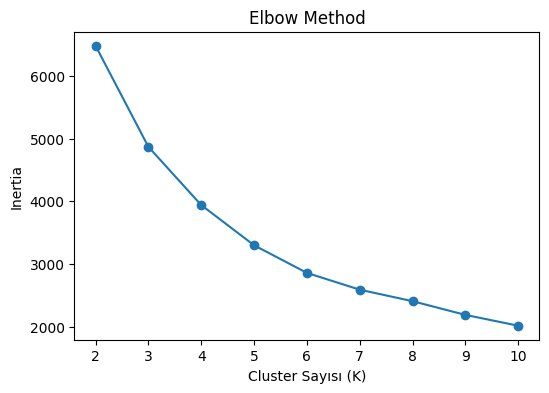

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Cluster Sayısı (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

## Optimal Cluster Sayısının Seçilmesi

Elbow Method grafiği incelendiğinde, cluster sayısı arttıkça inertia değerinin azaldığı görülmektedir.

Ancak K=4 değerinden sonra inertia düşüşünün yavaşladığı gözlemlenmiştir.
Bu nokta model karmaşıklığı ile performans arasındaki optimal dengeyi göstermektedir.

Bu nedenle çalışmada müşteri segmentasyonu için 4 cluster kullanılması tercih edilmiştir.

In [19]:
rfm.to_csv("../data/processed/customer_rfm.csv", index=False)